https://youtu.be/HtE1nsZsd98

**The code performs interpolation on an input 3D image (array) to create a new image with adjusted pixel size and slice thickness.** <p>
by using RegularGridInterpolator from SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RegularGridInterpolator.html <p>
It takes a 3D grid of values with certain intervals, adjusts the grid dimensions and fills in the values using interpolation to create a new 3D image with the desired pixel size and slice thickness. <p>
FIB-SEM and volumetric EM data are typically acquired with specific pixel sizes and slice thicknesses where slice thickness usually containing lower resolution (thicker slices) compared to x/y pixel dimensions. Therefore, it may be necessary to change these parameters to match specific requirements, such as downstream analysis methods requiring isometric voxels. The code allows for adjusting the pixel size and slice thickness, ensuring the resulting data is consistent with the desired parameters. <p>
Dataset from: https://paperswithcode.com/dataset/3d-platelet-em <br>
Image voxels are approximately 40x10x10 nm <p>

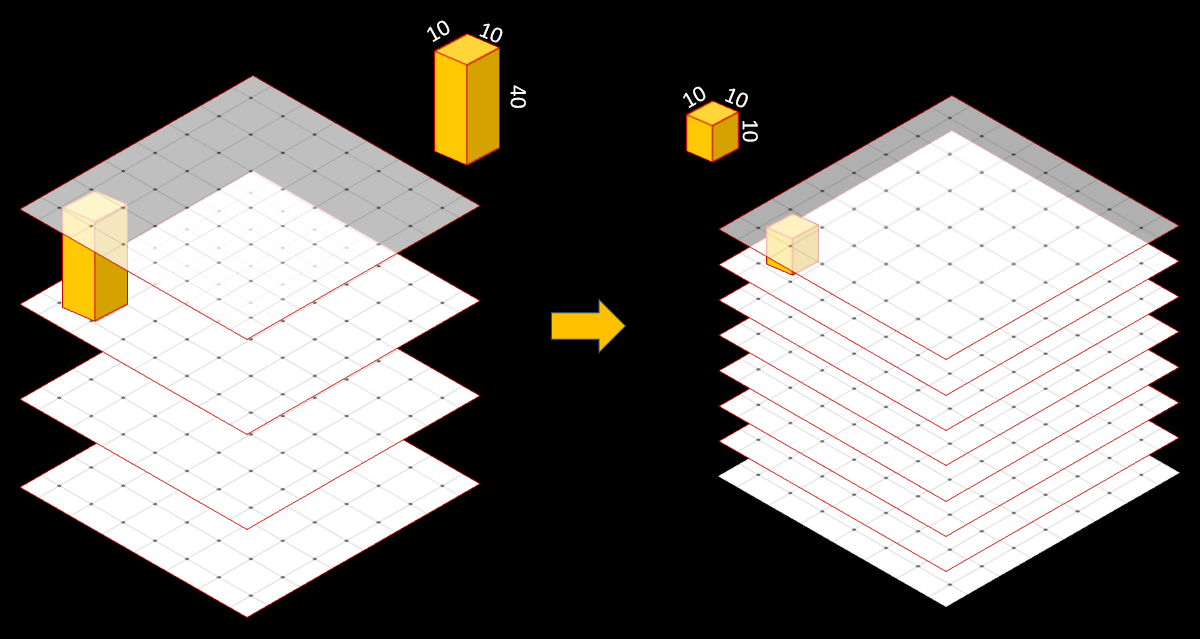

In [ ]:
from scipy.interpolate import RegularGridInterpolator
from skimage import io, img_as_ubyte
from matplotlib import pyplot as plt
import numpy as np
from tifffile import imsave, imwrite

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_image = io.imread("/content/512_512_3D_stardist_test.tif")

In [ ]:
input_image.shape
# (50 x 800 x 800) at 40x10x10 nm

(68, 512, 512)

In [ ]:
pixelsize_old = 0.65
slice_thickness_old = 2.45

pixelsize_new = 0.65
slice_thickness_new = 0.65

Create arrays x_old, y_old, and z_old to represent the coordinates of the input image along the x, y, and z axes respectively, based on the shape and pixel size information of the input image.

In [ ]:
x_old = np.linspace(0, (input_image.shape[1]-1)*pixelsize_old, input_image.shape[1])
y_old = np.linspace(0, (input_image.shape[2]-1)*pixelsize_old, input_image.shape[2])
z_old = np.arange(0, (input_image.shape[0]))*slice_thickness_old

In [ ]:
print(x_old) # With spacing 10 the result would be: array([   0.,   10.,   20.,   30., ......]

[  0.     0.65   1.3    1.95   2.6    3.25   3.9    4.55   5.2    5.85
   6.5    7.15   7.8    8.45   9.1    9.75  10.4   11.05  11.7   12.35
  13.    13.65  14.3   14.95  15.6   16.25  16.9   17.55  18.2   18.85
  19.5   20.15  20.8   21.45  22.1   22.75  23.4   24.05  24.7   25.35
  26.    26.65  27.3   27.95  28.6   29.25  29.9   30.55  31.2   31.85
  32.5   33.15  33.8   34.45  35.1   35.75  36.4   37.05  37.7   38.35
  39.    39.65  40.3   40.95  41.6   42.25  42.9   43.55  44.2   44.85
  45.5   46.15  46.8   47.45  48.1   48.75  49.4   50.05  50.7   51.35
  52.    52.65  53.3   53.95  54.6   55.25  55.9   56.55  57.2   57.85
  58.5   59.15  59.8   60.45  61.1   61.75  62.4   63.05  63.7   64.35
  65.    65.65  66.3   66.95  67.6   68.25  68.9   69.55  70.2   70.85
  71.5   72.15  72.8   73.45  74.1   74.75  75.4   76.05  76.7   77.35
  78.    78.65  79.3   79.95  80.6   81.25  81.9   82.55  83.2   83.85
  84.5   85.15  85.8   86.45  87.1   87.75  88.4   89.05  89.7   90.35
  91. 

In [ ]:
print(z_old) # # With spacing 40 the result would be: array([    0,   40,   80,  120,  ......]

[  0.     2.45   4.9    7.35   9.8   12.25  14.7   17.15  19.6   22.05
  24.5   26.95  29.4   31.85  34.3   36.75  39.2   41.65  44.1   46.55
  49.    51.45  53.9   56.35  58.8   61.25  63.7   66.15  68.6   71.05
  73.5   75.95  78.4   80.85  83.3   85.75  88.2   90.65  93.1   95.55
  98.   100.45 102.9  105.35 107.8  110.25 112.7  115.15 117.6  120.05
 122.5  124.95 127.4  129.85 132.3  134.75 137.2  139.65 142.1  144.55
 147.   149.45 151.9  154.35 156.8  159.25 161.7  164.15]


Pick appropriate method for interpolation. Based on your data size, you may be restricted to using linear as others require large amount of memory.

In [ ]:
method = "linear"    # “linear”, “nearest”, “slinear”, “cubic”, “quintic” and “pchip”

 Create a RegularGridInterpolator object using the old coordinates and the input image data. This object will be used to perform the interpolation.<p>
 The underlying algorithm used by RegularGridInterpolator is known as piecewise linear interpolation. It works by dividing the grid into smaller hypercubes and performing linear interpolation within each hypercube. <p>
 When you create an instance of RegularGridInterpolator, you provide the grid points and the corresponding values at those points. Once you have created the interpolator, you can use it to evaluate the interpolated values at any point within the grid's bounding box. The interpolator uses the provided grid points and values to determine the hypercube that contains the target point. It then performs linear interpolation within that hypercube to compute the interpolated value. <p>
 RegularGridInterpolator also allows for extrapolation, which means it can compute interpolated values even for points outside the original grid's bounding box. By default, it uses the boundary values of the grid for extrapolation, but you can also specify custom boundary conditions if needed.

In [ ]:
 my_interpolating_object = RegularGridInterpolator((z_old, x_old, y_old), input_image, method=method, bounds_error=False)

Calculate the new sizes for the x, y, and z dimensions based on the old sizes and pixel sizes.

In [ ]:
x_new = np.round(input_image.shape[1]*pixelsize_old/pixelsize_new).astype('int')
y_new = np.round(input_image.shape[2]*pixelsize_old/pixelsize_new).astype('int')
z_new = np.arange(z_old[0], z_old[-1], slice_thickness_new)

In [ ]:
print(z_new) # With spacing 20 the result would be: array([    0,   20,   40,  60,  ......]

[  0.     0.65   1.3    1.95   2.6    3.25   3.9    4.55   5.2    5.85
   6.5    7.15   7.8    8.45   9.1    9.75  10.4   11.05  11.7   12.35
  13.    13.65  14.3   14.95  15.6   16.25  16.9   17.55  18.2   18.85
  19.5   20.15  20.8   21.45  22.1   22.75  23.4   24.05  24.7   25.35
  26.    26.65  27.3   27.95  28.6   29.25  29.9   30.55  31.2   31.85
  32.5   33.15  33.8   34.45  35.1   35.75  36.4   37.05  37.7   38.35
  39.    39.65  40.3   40.95  41.6   42.25  42.9   43.55  44.2   44.85
  45.5   46.15  46.8   47.45  48.1   48.75  49.4   50.05  50.7   51.35
  52.    52.65  53.3   53.95  54.6   55.25  55.9   56.55  57.2   57.85
  58.5   59.15  59.8   60.45  61.1   61.75  62.4   63.05  63.7   64.35
  65.    65.65  66.3   66.95  67.6   68.25  68.9   69.55  70.2   70.85
  71.5   72.15  72.8   73.45  74.1   74.75  75.4   76.05  76.7   77.35
  78.    78.65  79.3   79.95  80.6   81.25  81.9   82.55  83.2   83.85
  84.5   85.15  85.8   86.45  87.1   87.75  88.4   89.05  89.7   90.35
  91. 

Generate a new grid of points pts using np.indices(), which represents the coordinates of the new image grid. Reshape the grid and transform into the appropriate format. Then, adjust the coordinates of the new grid points pts to match the new pixel size and slice thickness.

In [ ]:
# pts is the new grid
pts = np.indices((len(z_new), x_new, y_new)).transpose((1, 2, 3, 0))
pts = pts.reshape(1, len(z_new)*x_new*y_new, 1, 3).reshape(len(z_new)*x_new*y_new, 3)
pts = np.array(pts, dtype=float)
pts[:, 1:3] = pts[:, 1:3]*pixelsize_new
pts[:, 0] = pts[:, 0]*slice_thickness_new +z_new[0]

In [ ]:
pts.shape

(66322432, 3)

In [ ]:
print("Total z slices = ", pts.shape[0]/(input_image.shape[1]*input_image.shape[2]))

Total z slices =  253.0


Perform interpolation by calling the my_interpolating_object on the new grid points pts. Then reshape interpolated_data to match the new dimensions of the interpolated image.

In [ ]:
# Interpolate
interpolated_data = my_interpolating_object(pts)
interpolated_data = interpolated_data.reshape(len(z_new), x_new, y_new)

In [ ]:
interpolated_data.shape

(253, 512, 512)

Convert to 8 bit (or 16 bit) before saving so you can open in other image visualization and analysis software.

In [ ]:
#interpolated_data_16bit = interpolated_data.astype(np.uint16)

In [ ]:
interpolated_data_16bit = (np.round(((interpolated_data - interpolated_data.min())/interpolated_data.max()) * 65535.0)).astype(np.uint16)

Save the output as tiff image. You can use tifffile library to embed metadata, especially if you intend to use imageJ (FiJi) program for analysis. https://imagej.net/software/fiji/

In [ ]:
um_to_nm_scaling = 1000
metadata={'spacing': slice_thickness_new/um_to_nm_scaling, 'unit': 'um', 'axes': 'ZYX'}
imwrite("interpolated_image.tif", interpolated_data_16bit, imagej=True,
        resolution=(1/pixelsize_new*um_to_nm_scaling, 1/pixelsize_new*um_to_nm_scaling), metadata=metadata)


In [ ]:
voxelsize_x = 0.65
voxelsize_y = 0.65
voxelsize_z = 2.45

In [ ]:
pip install pocl-binary-distribution

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 10.3 MB/s eta 0:00:00


In [ ]:
pip install pyclesperanto-prototype


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.9/617.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 941.9/941.9 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
from skimage import io
from skimage.transform import rescale


In [ ]:
import pyclesperanto_prototype as cle


In [ ]:
from matplotlib import pyplot as plt


In [ ]:
print("Available OpenCL devices:" + str(cle.available_device_names()))


Available OpenCL devices:['pthread-Intel(R) Xeon(R) CPU @ 2.20GHz']


In [ ]:
# insert the name of GPU from previous code here
device = cle.select_device('pthread-Intel(R) Xeon(R) CPU @ 2.00GHz')
print("Used GPU: ", device)

Used GPU:  <pthread-Intel(R) Xeon(R) CPU @ 2.20GHz on Platform: Portable Computing Language (2 refs)>


/usr/local/lib/python3.10/dist-packages/pyclesperanto_prototype/_tier0/_device.py:77: UserWarning: No OpenCL device found with pthread-Intel(R) Xeon(R) CPU @ 2.00GHz in their name. Using pthread-Intel(R) Xeon(R) CPU @ 2.20GHz instead.
  warnings.warn(f"No OpenCL device found with {name} in their name. Using {device.name} instead.")


/usr/local/lib/python3.10/dist-packages/pyclesperanto_prototype/_tier9/_imshow.py:46: UserWarning: The imshow parameter color_map is deprecated. Use colormap instead.
  warnings.warn("The imshow parameter color_map is deprecated. Use colormap instead.")


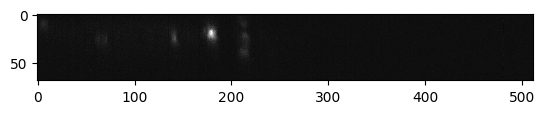

In [ ]:
img_gpu = cle.push(input_image)
cle.imshow(img_gpu[:,:,250], color_map='gray')

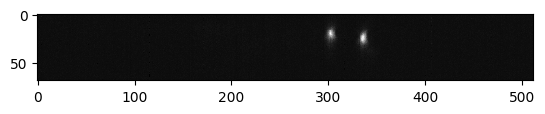

In [ ]:
cle.imshow(img_gpu[:,250,:], color_map='gray')

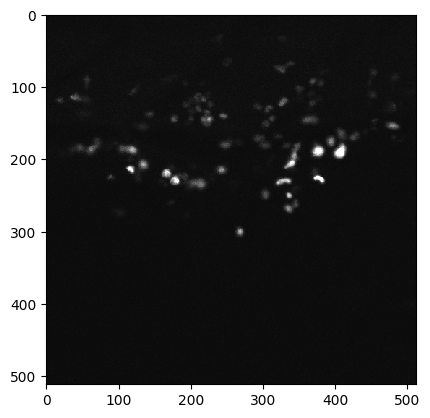

In [ ]:
cle.imshow(img_gpu[25,:,:], color_map='gray')

In [ ]:
!pip install stardist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

In [ ]:
StarDist2D.from_pretrained()


There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None


In [ ]:
model = StarDist2D.from_pretrained('2D_versatile_fluo')


Found model '2D_versatile_fluo' for 'StarDist2D'.
5320433/5320433 [==============================] - 0s 0us/step
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [ ]:
img_xy = img_gpu[25,:,:]
img_xz = img_gpu[:,250,:]
img_yz = img_gpu[:,:,250]

In [ ]:
labels_xy , _ = model.predict_instances(normalize(img_xy))


In [ ]:
labels_xz , _ = model.predict_instances(normalize(img_xz))


In [ ]:
labels_yz , _ = model.predict_instances(normalize(img_yz))


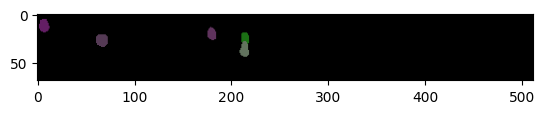

In [ ]:
plt.imshow(render_label(labels_yz))
